
*auteurs : Romane Gouineaud, Mathias Muhulet, Simon Perrigault, Luc Samain, Gabin Jousst-Dubien, Eugénie Palisser*
# Analyse et Prédiction des Émissions CO2 des Véhicules

Ce notebook analyse un dataset de véhicules et développe un modèle de prédiction des émissions CO2.

In [8]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [9]:
# Chargement des données nettoyées
data = pd.read_csv('./files/train.csv')
print(f"Nombre total d'entrées : {len(data)}")
data.head()

Nombre total d'entrées : 41257


,id,brand,model,car_class,range,fuel_type,hybrid,max_power,grbx_type_ratios,weight_min,weight_max,urb_cons,exturb_cons,overall_cons,co,hc,nox,hcnox,ptcl,co2
0,0,MERCEDES,COMBI 110 CDI,MINIBUS,MOY-INFER,GO,non,70.0,M 6,1976,2075,9.1,6.4,7.4,0.083,NaN,0.229,0.250,0.001,195
1,1,MERCEDES,VIANO 2.0 CDI,MINIBUS,MOY-SUPER,GO,non,100.0,A 5,2186,2355,10.2,7.0,8.2,0.078,NaN,0.224,0.233,0.001,216
2,2,MERCEDES,SPRINTER COMBI 319 CDI,MINIBUS,MOY-INFER,GO,non,140.0,A 5,2586,2869,12.5,9.0,10.3,0.067,0.014,1.846,NaN,0.002,272
3,3,RENAULT,MEGANE Coupé EnergyTCe (115ch) eco2,COUPE,MOY-INFER,ES,non,85.0,M 6,1280,1280,6.4,4.6,5.3,0.167,0.039,0.039,NaN,0.001,119
4,4,MERCEDES,COMBI 116 CDI,MINIBUS,MOY-INFER,GO,non,120.0,A 5,2356,2450,10.1,6.9,8.1,0.042,NaN,0.190,0.201,0.001,214


## 1. Analyse Exploratoire des Données

Pour commencer, on peut simplement faire une matrice des corrélations pour voir si des données sont plus ou moins corrélées entre elles. On s'intéresse spécifiquement à la donnée CO2 et on regarde avec quelle autre donnée elle est le plus corrélée. 

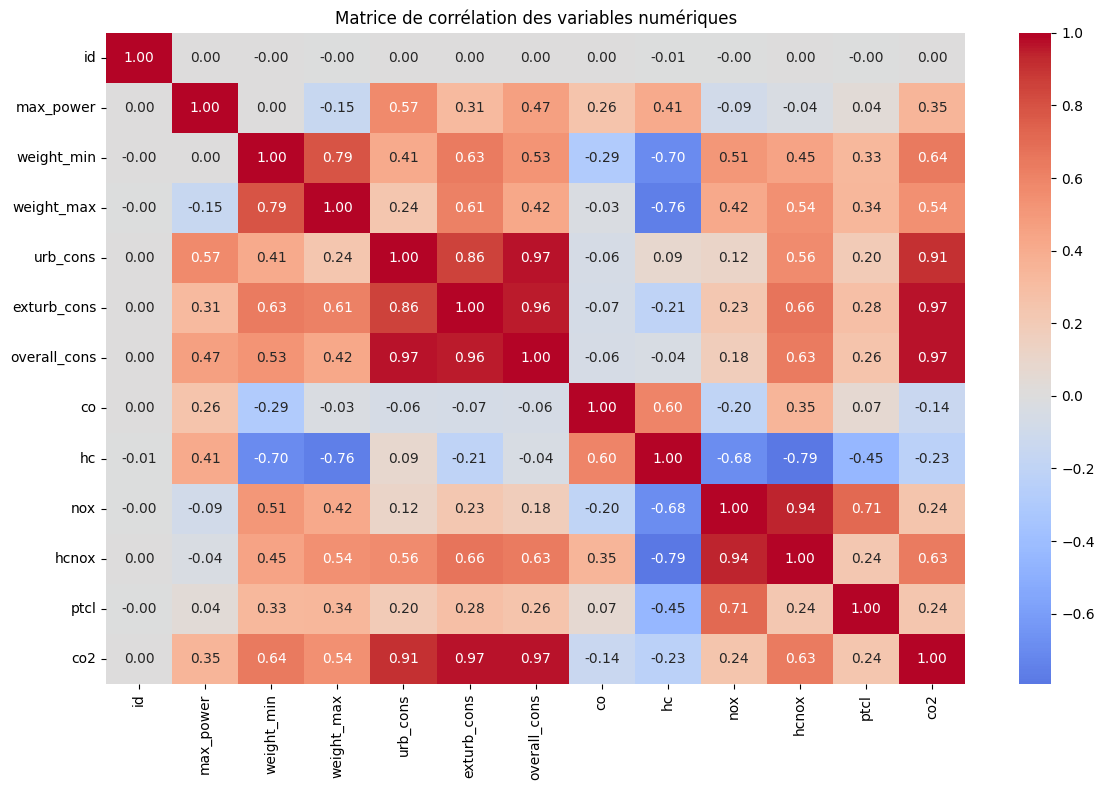

In [10]:
# Sélection des colonnes numériques
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
numeric_data = data[numeric_columns]

# Création de la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matrice de corrélation des variables numériques')
plt.tight_layout()
plt.show()

On remarque alors que la donnée CO2 est très corrélée avec les 3 données suivantes : 
- urb_cons
- exturb_cons
- overall_cons

Cela semble logique que la production de CO2 soit corrélée à la consommation des véhicules. 
De plus on peut remarqué une corrélation plus légère avec les données de poids et de hcnox. Ces corrélations parraissent toutes aussi logiques que les premières.

On sait donc maintenant que les données corrélées avec la production de CO2 sont les plus importante pour notre modèle, on va donc essayer de favoriser ces données par rapprot aux autres. 

De plus cette matrice de corrélation met en évidence une chose évidente, l'ID n'est absolument pas corrélé à la consommation de CO2. Cela est évident mais il faudra bien penser à le retirer du jeu de données plus tard (on le gardera juste pour indiquer les résultats). Cet exemple est évident mais on aurait pu faire pareil avec n'importe qu'elle autre donnée qui n'a aucun corrélation avec la production de CO2 des véhicules.

# Analyse des variables catégorielles

Certaines données dans notre jeu de données ne sont pas des caractères numériques, on va commencer par les analyser pour savoir ce qu'on peut en faire

In [11]:
categorical_columns = data.select_dtypes(include=['object']).columns

# Affichage des valeurs uniques pour chaque variable catégorielle
for col in categorical_columns:
    print(f"\nValeurs uniques dans {col}:")
    print(data[col].value_counts().head())
    print(f"Nombre total de valeurs uniques: {data[col].nunique()}")


Valeurs uniques dans brand:
brand
MERCEDES      27127
VOLKSWAGEN    10266
FIAT            394
BMW             342
OPEL            308
Name: count, dtype: int64
Nombre total de valeurs uniques: 44

Valeurs uniques dans model:
model
VIANO 2.2 CDI    4405
VIANO 2.0 CDI    2931
COMBI 116 CDI    2847
COMBI 113 CDI    1968
VIANO 3.0 CDI    1180
Name: count, dtype: int64
Nombre total de valeurs uniques: 3141

Valeurs uniques dans car_class:
car_class
MINIBUS                34570
BERLINE                 3307
BREAK                    933
TS TERRAINS/CHEMINS      819
COUPE                    661
Name: count, dtype: int64
Nombre total de valeurs uniques: 11

Valeurs uniques dans range:
range
MOY-INFER     25118
MOY-SUPER     11275
LUXE           2677
SUPERIEURE     1163
INFERIEURE      800
Name: count, dtype: int64
Nombre total de valeurs uniques: 7

Valeurs uniques dans fuel_type:
fuel_type
GO       36993
ES        3853
EH         233
GH          63
GN/ES       27
Name: count, dtype: int64
Nomb

# Graphiques

On trace différents graphiques sur les émission de CO2, pour se rendre compte de sa répartition parmi les autre gaz.

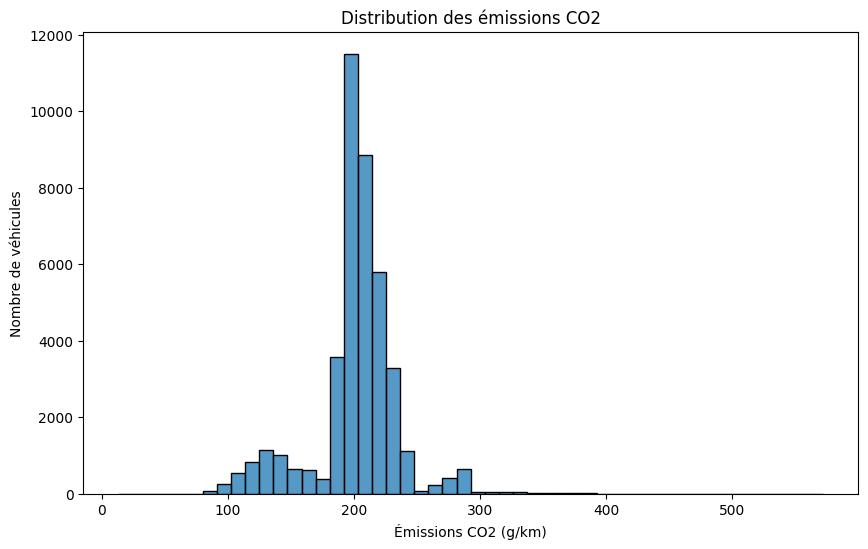

In [12]:
# Distribution des émissions CO2
plt.figure(figsize=(10, 6))
sns.histplot(data['co2'], bins=50)
plt.title('Distribution des émissions CO2')
plt.xlabel('Émissions CO2 (g/km)')
plt.ylabel('Nombre de véhicules')
plt.show()

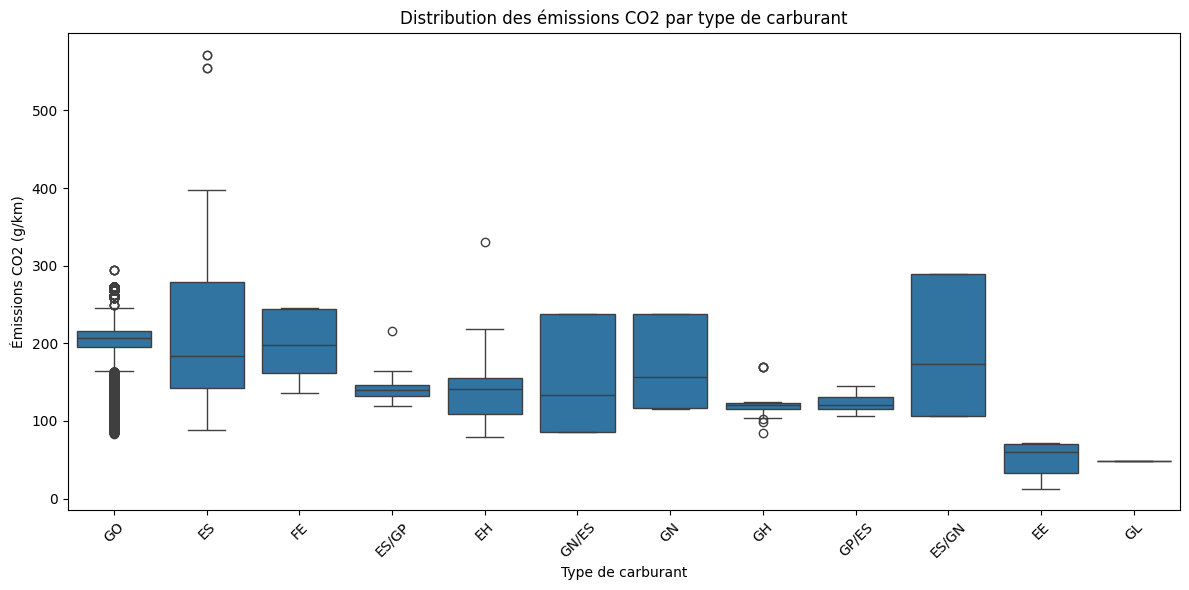

In [13]:
# Distribution des émissions CO2 par type de carburant
plt.figure(figsize=(12, 6))
sns.boxplot(x='fuel_type', y='co2', data=data)
plt.title('Distribution des émissions CO2 par type de carburant')
plt.xlabel('Type de carburant')
plt.ylabel('Émissions CO2 (g/km)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ces données n'ont pas été particulièrement utile. Cependant il est important d'essayer de visualiser le plus possible les données que l'on a, car c'est grâce à cela que l'on peut réussir à trouver des optimisations plus tard.


## Préparation des Données

Maintenant que nous avons eu une vue assez clair des données, on peut les préparer au traitement. Cela consiste à sélectionner les données qui nous intéresse. Mais aussi à mettre en place des Pipeline (ou transformer) qui vont modifier nos données pour qu'elles soient plus facilement manipulables par les modèles.

On commence par remplacer les données manquantes : 
- Pour les valeurs numériques, on remplace par la moyenne des valeurs
- Pour les valeurs dites de catégorie, on remplace le vide par 'missing'

Puis on normalise les données numériques et on convertit les catégories, qui sont des lettres, en valeurs numériques. 

Ces transformations sont nécessaire pour le bon fonctionnement des algorithmes que nous allons utiliser.

In [51]:
# Sélection des features
numeric_features = ['max_power', 'weight_min', 'weight_max', 'urb_cons', 
                    'exturb_cons', 'overall_cons', 'co', 'hc', 'nox', 'hcnox', 'ptcl']
categorical_features = ['brand', 'car_class', 'range', 'fuel_type', 'hybrid', 'grbx_type_ratios','model']

# Création des transformers
# remplace les valeurs manquantes par la moyenne puis normalise les données
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# remplace les valeurs manquantes par "missing" et convertit les catégories en nombres
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


# Création du preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [52]:
#import des données de tests 
test_data = pd.read_csv('./files/test.csv')

# Séparation des features et de la target pour l'entraînement
X_train = data[numeric_features + categorical_features]
y_train = data['co2']

X_test = test_data[numeric_features + categorical_features]

## Modèles de Régression

Maintenant que nos données sont prêtes, on peut utiliser des modèles de régression.

Cette fonction va nous permettre d'essayer différents modèles avec les mêmes pipeline.

In [28]:
# Fonction d'évaluation des modèles
def evaluate_model(model, X_train, X_test, y_train, model_name):
    # Création du pipeline complet
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Entraînement
    pipeline.fit(X_train, y_train)
    
    # Prédictions sur le set de test
    y_pred = pipeline.predict(X_test)
    
    # Cross-validation sur les données d'entraînement
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    
    print(f"\nRésultats pour {model_name}:")
    print(f"Cross-validation R² scores: {cv_scores}")
    print(f"Moyenne CV R² score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    return y_pred, cv_scores.mean()

On test alors différents modèles : 
- LinearRegression : C'est le modèle le plus simple qui cherche à établir une relation linéaire entre les variables d'entrée et la cible (CO2). Il modélise la relation sous forme d'une équation linéaire : y = b₀ + b₁x₁ + b₂x₂ + ... + bₙxₙ.
- Ridge : Extension de la régression linéaire qui ajoute un terme de pénalité basé sur la norme L2 des coefficients pour éviter le surapprentissage.
- Lasso : Similaire à Ridge mais utilise la norme L1, ce qui peut réduire certains coefficients à zéro, réalisant ainsi une sélection de variables.
- DecisionTreeRegressor : Un arbre de décision est un modèle simple et intuitif qui divise récursivement les données selon des règles de décision pour créer des régions homogènes.
- RandomForestRegressor : Ensemble d'arbres de décision où chaque arbre est construit sur un sous-ensemble aléatoire des données et des variables.
- Gradient Boosting : Construit les arbres séquentiellement, chaque arbre corrigeant les erreurs des précédents.


In [17]:
# Test de différents modèles
models = {
    'Régression Linéaire': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'Arbre de Décision': DecisionTreeRegressor(max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Stockage des prédictions et des scores
predictions = {}
scores = {}

for name, model in models.items():
    y_pred, cv_score = evaluate_model(model, X_train, X_test, y_train, name)
    predictions[name] = y_pred
    scores[name] = cv_score

# Création du fichier de soumission avec le meilleur modèle
best_model_name = max(scores.items(), key=lambda x: x[1])[0]
submission = pd.DataFrame({
    'id': test_data['id'],
    'co2': predictions[best_model_name]
})

# Sauvegarde des prédictions
submission.to_csv('./files/submission.csv', index=False)
print(f"\nPrédictions sauvegardées dans submission.csv (meilleur modèle: {best_model_name})")
print(f"Score du meilleur modèle: {scores[best_model_name]:.4f}")


Résultats pour Régression Linéaire:
Cross-validation R² scores: [0.99895617 0.99888072 0.99929375 0.99915264 0.99940058]
Moyenne CV R² score: 0.9991 (+/- 0.0004)

Résultats pour Ridge:
Cross-validation R² scores: [0.99910148 0.99896631 0.99921797 0.99922801 0.99940409]
Moyenne CV R² score: 0.9992 (+/- 0.0003)

Résultats pour Lasso:
Cross-validation R² scores: [0.97145705 0.9753008  0.96910304 0.97535838 0.9765786 ]
Moyenne CV R² score: 0.9736 (+/- 0.0056)

Résultats pour Arbre de Décision:
Cross-validation R² scores: [0.99754104 0.99878637 0.99607803 0.99767947 0.99911529]
Moyenne CV R² score: 0.9978 (+/- 0.0021)

Résultats pour Random Forest:
Cross-validation R² scores: [0.99871823 0.99881071 0.99887929 0.99753803 0.99954371]
Moyenne CV R² score: 0.9987 (+/- 0.0013)

Résultats pour Gradient Boosting:
Cross-validation R² scores: [0.99824876 0.99794552 0.99786864 0.99775355 0.99828302]
Moyenne CV R² score: 0.9980 (+/- 0.0004)

Prédictions sauvegardées dans submission.csv (meilleur modè

On remarque dans les résultat que le modèle Ridge est le meilleur, cependant quand on test les résultats des modèles dans Kaggle on obtient des résultats assez différents. Effectivement le meilleur modèle semble plutôt etre le Random Forest, en tout cas, c'est celui qui obtient le meilleur score sur Kaggle. 

## 4. Analyse des Features Importantes

Maintenant que nous avons vu que l'algo le plus efficace est le RandomForestRegressor, on peut se concentrer dessus et essayer d'optimiser ces paramètres.
Pour ce faire, on va surtout s'intéresser au paramètre n_estimator qui correspond au nombre d'arbre qui seront crées dans la forêt aléatoire.

In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

def find_optimal_trees(X_train, y_train, n_estimators_range=[1,2,5,10,20,50,80,100,150,200,300,500,1000]):
    """Trouve le nombre optimal d'arbres pour le Random Forest"""
    cv_scores = []
    cv_stds = []
    
    for n_est in n_estimators_range:
        print(f"Test avec {n_est} arbres...")
        model = RandomForestRegressor(n_estimators=n_est, random_state=42)
        mean_score, std_score = evaluate_model(model, X_train, X_test, y_train, f"Random Forest ({n_est} arbres)")
        cv_scores.append(mean_score)
        cv_stds.append(std_score)
    
    return 

# Évaluation du modèle avec le nombre optimal d'arbres
optimal_n_trees = find_optimal_trees(X_train, y_train)

Test avec 1 arbres...

Résultats pour Random Forest (1 arbres):
Cross-validation R² scores: [0.9972547  0.99858884 0.99713218 0.99756741 0.99642126]
Moyenne CV R² score: 0.9974 (+/- 0.0014)
Test avec 2 arbres...

Résultats pour Random Forest (2 arbres):
Cross-validation R² scores: [0.99750738 0.99857291 0.99864656 0.99480484 0.99805467]
Moyenne CV R² score: 0.9975 (+/- 0.0028)


In [ ]:
## 4. Analyse des Features Importantes
model = RandomForestRegressor(n_estimators=n_est, random_state=42)

# Stockage des prédictions et des scores
predictions = {}
scores = {}

y_pred, cv_score = evaluate_model(model, X_train, X_test, y_train, name)
predictions = y_pred
scores = cv_score


submission = pd.DataFrame({
    'id': test_data['id'],
    'co2': predictions
})

# Sauvegarde des prédictions
submission.to_csv('./files/submission.csv', index=False)
print(f"\nPrédictions sauvegardées dans submission_finale.csv")
print(f"Score du meilleur modèle: {scores:.4f}")

Nous avons trouvé un modèle (RandomForestRegressor) et des paramètres qui ont de très bons résultats. Notre modèle est suffisamment bon pour prédire les émissions de CO2 des voitures.

On pourrait cependant poursuivre nos recherches pour encore améliorer l'efficacité de notre modèle, en utilisant d'autres modèles comme (XGBRegressor,LGBMRegressor), cependant ces modèles sont complexes et demandes beaucoup de temps pour être optimisé (pour tester différentes configurations et trouver les meilleurs paramètres). 

Dans un souci d'économie de temps et surtout pour éviter de laisser des machines tourner dans le "vide" pendant des heures nous avons préféré ne pas chercher à optimiser ces nouveaux modèles, qui auraient pu nous faire améliorer notre score (ou pas) mais qui aurait surtout demandé beaucoup de temps de calcul. 